#kaggle的Predict Calorie Expenditure

In [ ]:
!unzip playground-series-s5e5.zip && rm -rf playground-series-s5e5.zip

Archive:  playground-series-s5e5.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
#基础数据预处理->随机森林基准模型->重要性测试->特征工程优化比对基准
#autogluon找到模型和超参数->对应模型实现融合

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#基本数据预处理（包括eda分析+基本的数据清洗）
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def load_data(train_path='train.csv', test_path='test.csv'):
    """加载数据"""
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

def basic_eda(df):
    """基础EDA"""
    print("数据形状:", df.shape)
    print("\n前5行:")
    print(df.head())
    print("\n数据类型:")
    print(df.dtypes)
    print("\n缺失值:")
    print(df.isnull().sum())

def basic_preprocess(train, test, test_size=0.2, random_state=42):
    """基础预处理"""
    # 合并处理
    all_data = pd.concat([train, test], ignore_index=True).copy()

    # 填充缺失值
    for col in all_data.columns:
        if all_data[col].isnull().sum() > 0:
            if all_data[col].dtype == 'object':
                all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
            else:
                all_data[col] = all_data[col].fillna(all_data[col].median())

    # 编码分类变量
    for col in all_data.columns:
        if all_data[col].dtype == 'object' and col != 'Calories':
            le = LabelEncoder()
            all_data[col] = le.fit_transform(all_data[col].astype(str))

    # 分离数据
    train_processed = all_data[:len(train)].copy().reset_index(drop=True)
    test_processed = all_data[len(train):].copy().reset_index(drop=True)

    # 分离特征和目标
    feature_cols = [col for col in train_processed.columns if col not in ['id', 'Calories']]
    X = train_processed[feature_cols]
    y = train_processed['Calories']
    X_test = test_processed[feature_cols]  # 竞赛测试集

    # 从训练集分出验证集
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    print(f"预处理完成:")
    print(f"训练集: {X_train.shape}")
    print(f"验证集: {X_val.shape}")
    print(f"竞赛测试集: {X_test.shape}")
    print(f"特征: {X.columns.tolist()}")

    return X_train, X_val, y_train, y_val, X_test

train, test = load_data()
basic_eda(train)
X_train, X_val, y_train, y_val, X_test = basic_preprocess(train, test)

数据形状: (750000, 9)

前5行:
   id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0   0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1   1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2   2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3   3    male   20   192.0    90.0      25.0       105.0       40.7     140.0
4   4  female   38   166.0    61.0      25.0       102.0       40.6     146.0

数据类型:
id              int64
Sex            object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object

缺失值:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64
预处理完成:
训练集: (600000, 7)
验证集: (150000, 7)
竞赛测试集: (250000, 7)
特征: ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', '

In [ ]:
#构建随机森林基准模型
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_log_error
import numpy as np

# RMSLE评分器
rmsle_scorer = make_scorer(
   lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred)),
   greater_is_better=False
)

baseline_model = RandomForestRegressor(n_estimators=30, random_state=42, max_depth=10, n_jobs=-1)
baseline_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring=rmsle_scorer)

print(f"Baseline CV RMSLE: {-baseline_scores.mean():.6f} (+/- {baseline_scores.std() * 2:.6f})")

Baseline CV RMSLE: 0.080222 (+/- 0.002578)


正在分析特征重要性...

=== 特征重要性分析 ===
排序 | 特征名称     | 重要性得分 | 占比% | 累计%
------------------------------------------------------------
 1   | Duration     |   0.9279 |  92.8 |  92.8
 2   | Heart_Rate   |   0.0411 |   4.1 |  96.9
 3   | Age          |   0.0223 |   2.2 |  99.1
 4   | Sex          |   0.0059 |   0.6 |  99.7
 5   | Weight       |   0.0019 |   0.2 |  99.9
 6   | Height       |   0.0006 |   0.1 | 100.0
 7   | Body_Temp    |   0.0003 |   0.0 | 100.0

关键发现:
- 前1个特征覆盖80%的预测能力
- 最重要特征: Duration (92.8%)
- 前3个特征贡献度: 99.1%


<ipython-input-25-2462423563>:65: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-25-2462423563>:65: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-25-2462423563>:65: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-25-2462423563>:65: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-25-2462423563>:65: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-25-2462423563>:65: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-25-2462423563>:65: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) DejaV

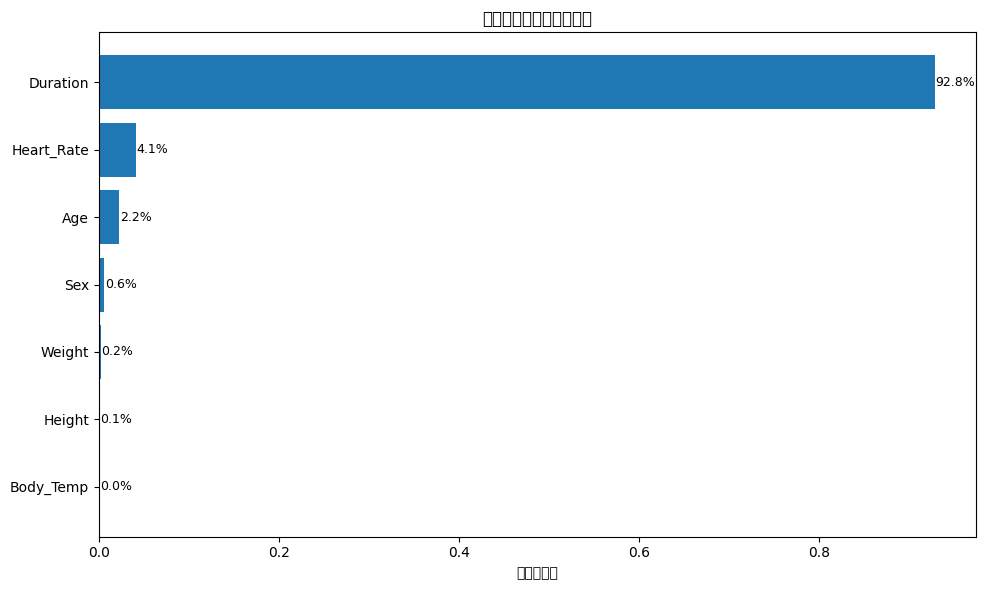

,feature,importance,percentage,cumulative_pct
4,Duration,0.927949,92.794946,92.794946
5,Heart_Rate,0.041074,4.107409,96.902355
1,Age,0.022283,2.228272,99.130627
0,Sex,0.005929,0.592923,99.723550
3,Weight,0.001863,0.186332,99.909882
2,Height,0.000634,0.063356,99.973238
6,Body_Temp,0.000268,0.026762,100.000000


In [ ]:
def analyze_feature_importance(X_train, X_val, y_train, y_val, plot=True, top_n=None, random_state=42):
    """
    随机森林特征重要性分析
    """
    # 训练模型
    rf = RandomForestRegressor(
        n_estimators=200,
        random_state=random_state,
        n_jobs=-1,
        max_depth=15  # 建议添加：避免过拟合，加速训练
    )

    print("正在分析特征重要性...")
    rf.fit(X_train, y_train)

    # 获取特征重要性
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    if top_n:
        importance_df = importance_df.head(top_n)

    # 计算百分比和累计百分比
    total_importance = importance_df['importance'].sum()
    importance_df['percentage'] = (importance_df['importance'] / total_importance) * 100
    importance_df['cumulative_pct'] = importance_df['percentage'].cumsum()

    # 打印分析结果
    print(f"\n=== 特征重要性分析 ===")
    print("排序 | 特征名称     | 重要性得分 | 占比% | 累计%")  # 调整格式
    print("-" * 60)  # 增加分隔线长度

    for i, (_, row) in enumerate(importance_df.iterrows(), 1):
        print(f"{i:2d}   | {row['feature']:12s} | {row['importance']:8.4f} | {row['percentage']:5.1f} | {row['cumulative_pct']:5.1f}")

    # 找出覆盖80%重要性的特征数量
    top_80_count = len(importance_df[importance_df['cumulative_pct'] <= 80])
    if top_80_count == 0:
        top_80_count = 1

    print(f"\n关键发现:")
    print(f"- 前{top_80_count}个特征覆盖80%的预测能力")
    print(f"- 最重要特征: {importance_df.iloc[0]['feature']} ({importance_df.iloc[0]['percentage']:.1f}%)")

    if len(importance_df) >= 3:
        top3_pct = importance_df.head(3)['percentage'].sum()
        print(f"- 前3个特征贡献度: {top3_pct:.1f}%")

    # 绘制重要性图
    if plot:
        plt.figure(figsize=(10, 6))
        bars = plt.barh(range(len(importance_df)), importance_df['importance'])
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('import score')
        plt.title('rf important analysis')
        plt.gca().invert_yaxis()

        # 添加数值标签
        for i, (bar, pct) in enumerate(zip(bars, importance_df['percentage'])):
            plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                    f'{pct:.1f}%', va='center', fontsize=9)

        plt.tight_layout()
        plt.show()

    return importance_df

analyze_feature_importance(X_train, X_val, y_train, y_val)

In [ ]:
#特征工程,不需要复杂特征工程

In [ ]:
#autogluon构建模型
import autogluon as ag
from autogluon.tabular import TabularDataset, TabularPredictor

data_train = np.column_stack([X_train, y_train])
data_val = np.column_stack([X_val, y_val])
print(data_train.shape, data_val.shape, X_test.shape)

data_train = pd.DataFrame(data_train, columns=X_train.columns.tolist() + ['Calories'])
data_val = pd.DataFrame(data_val, columns=X_train.columns.tolist() + ['Calories'])
data_test = pd.DataFrame(X_test, columns=X_train.columns.tolist())

predictor = TabularPredictor(label='Calories',problem_type='regression',eval_metric='root_mean_squared_error')
model = predictor.fit(
    train_data=data_train,
    time_limit=1800,
    presets='best_quality',
    num_bag_folds=5,
    num_stack_levels=1,
    hyperparameters={
        'GBM': {},  # XGBoost/LightGBM
        'CAT': {},  # CatBoost
        'RF': {'n_estimators': [100, 200]},  # Random Forest
        'XT': {'n_estimators': [100, 200]},  # Extra Trees
        'NN_TORCH': {},  # Neural Network
    }
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250618_181813"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          8
Memory Avail:       48.12 GB / 50.99 GB (94.4%)
Disk Space Avail:   183.28 GB / 225.83 GB (81.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will b

(600000, 8) (150000, 8) (250000, 7)


Leaderboard on holdout data (DyStack):
                   model  score_holdout  score_val              eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    WeightedEnsemble_L2      -3.518993  -3.542574  root_mean_squared_error       12.285736      67.846289  234.000488                 0.002892                0.004720           0.161441            2       True          4
1        CatBoost_BAG_L1      -3.520994  -3.555323  root_mean_squared_error        0.435212       0.286187  182.913052                 0.435212                0.286187         182.913052            1       True          2
2    WeightedEnsemble_L3      -3.522000  -3.538204  root_mean_squared_error       13.924202      74.134022  393.012217                 0.003416                0.004307           0.280639            3       True          8
3        LightGBM_BAG_L2      -3.536113  -3.556977  root_mean_squared_err

In [ ]:
from sklearn.metrics import mean_squared_log_error

predictions = model.predict(data_val.drop('Calories', axis=1))
actual = data_val['Calories']

# 计算RMSLE
rmsle = np.sqrt(mean_squared_log_error(actual, predictions))
print(f"手动计算的RMSLE: {rmsle:.4f}")

手动计算的RMSLE: 0.0603


In [ ]:
model.evaluate(data_val)

{'root_mean_squared_error': np.float64(-3.532843588371504),
 'mean_squared_error': -12.480983819897645,
 'mean_absolute_error': -2.1056778448176385,
 'r2': 0.9967796125877895,
 'pearsonr': 0.9983885095808434,
 'median_absolute_error': np.float64(-1.3116130828857422)}

In [ ]:
model.leaderboard(data_val)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-3.532844,-3.543655,root_mean_squared_error,26.224344,67.924939,439.815803,0.003109,0.005133,0.204280,2,True,4
1,CatBoost_BAG_L1,-3.540265,-3.553125,root_mean_squared_error,0.383123,0.356173,376.654317,0.383123,0.356173,376.654317,1,True,2
2,LightGBM_BAG_L1,-3.564344,-3.604747,root_mean_squared_error,25.838112,67.563633,62.957206,25.838112,67.563633,62.957206,1,True,1
3,NeuralNetTorch_BAG_L1,-5.219318,-5.387333,root_mean_squared_error,1.622074,1.416243,193.253850,1.622074,1.416243,193.253850,1,True,3


In [ ]:
test_pred = model.predict(data_test)
test_pred.head()

,Calories
0,27.305286
1,108.045677
2,87.245377
3,125.890236
4,75.938126


In [ ]:
#提交部分
test_id = pd.read_csv('test.csv')['id']
submission = pd.DataFrame({'id': test['id'], 'Calories': test_pred})
submission.to_csv('submission.csv',index=False)

In [ ]:
# 直接使用numpy数组避免索引问题
submission_fixed = pd.DataFrame({
    'id': test['id'].values.astype(int),        # 使用.values
    'Calories': test_pred.values.astype(float)  # 使用.values
})

print("=== 使用values的版本 ===")
print(submission_fixed.head())
print(f"形状: {submission_fixed.shape}")

submission_fixed.to_csv('submission_values.csv', index=False)
print("Values版本已保存")

=== 使用values的版本 ===
       id    Calories
0  750000   27.305286
1  750001  108.045677
2  750002   87.245377
3  750003  125.890236
4  750004   75.938126
形状: (250000, 2)
Values版本已保存
